nbCores: 1 nbReps: 1 Horizon: 1000
nbCores: 1 nbReps: 1 Horizon: 1000
nbCores: 1 nbReps: 1 Horizon: 1000


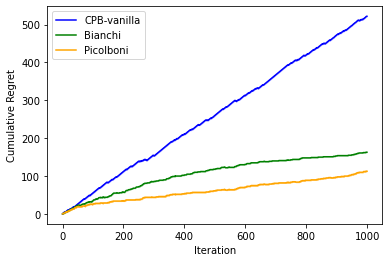

In [9]:
from sklearn.linear_model import SGDClassifier
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import geometry
import itertools
from collections import defaultdict
import collections
import target
import controler
import utils
from functools import reduce
import linear_regression
from multiprocessing import Pool
from functools import partial
import numpy as np
import geometry
import itertools 
from itertools import islice


class SyntheticCase:

    def __init__(self, LossMatrix, FeedbackMatrix, horizon ):
 
        self.LossMatrix = LossMatrix 
        self.FeedbackMatrix = FeedbackMatrix 
        self.horizon = horizon
        self.n_actions = len(self.LossMatrix)

    def parameters_Bianchi(self, C):
        # [Bianchi et al. 2006 "Regret minimization under partial monitoring"]
        eta = 1 / C * pow( np.log( self.n_actions ) / ( self.n_actions * self.horizon ) , 2./3.) 
        gamma = C * pow( ( np.log( self.n_actions ) * self.n_actions **2) / self.horizon , 1./3.)
        return eta, gamma 

    def parameters_Piccolboni(self, ):
        ## [Piccolboni Schindelhauer "Discrete Prediction Games with Arbitrary Feedback and Loss" 2000]
        ## fixed-known-horizon settings
        eta = pow( np.log(self.n_actions), 1./2.) / pow(self.horizon, 1./2.)
        gamma = np.fmin(1., pow(self.n_actions, 1./2.) * pow( np.log(self.n_actions),1./4.) / pow(self.horizon, 1./4.))
        return eta, gamma
        
    def feedexp3(self, method, job_id):
        np.random.seed(job_id)

        self.LinkMatrix = np.linalg.lstsq(self.FeedbackMatrix, self.LossMatrix,rcond=None )[0]
        k_star = max( [1, np.fabs(self.LinkMatrix).max() ] )
        C = pow( k_star * np.sqrt(np.exp(1.)-2.), 2./3.)

        w = np.ones(self.n_actions)
        cumRegret = []
        cumAllLosses, cumSufferedLoss = 0 , 0 

        if method == 'Bianchi' :
            eta, gamma = self.parameters_Bianchi(C) 
        else:
            eta, gamma = self.parameters_Piccolboni()

        for t in range(self.horizon):

            pbt = [ (1-gamma) * w[i] / sum(w)  + gamma/self.n_actions for i in range(self.n_actions)]
            action = np.random.choice([0,1], p=pbt )

            outcome = np.random.choice([0,1], p=[0.9, 0.1] )
            feedback = self.FeedbackMatrix[action, outcome]

            for i in range(self.n_actions):
                l_i = self.LinkMatrix[i,action] * feedback / pbt[action]
                w[i] = w[i] * np.exp(-eta * l_i)

            # policy suffers loss and regret
            cumAllLosses += self.LossMatrix[...,outcome]
            cumSufferedLoss += self.LossMatrix[action,outcome]
            cumRegret.append(  cumSufferedLoss - min(cumAllLosses) )

        return np.array(cumRegret)

    def W(self, mathcal_N, N_bar, observer_vector ):
        W = np.zeros( len(N_bar) )
        for pair in mathcal_N:
            for k in N_bar:
                value = np.fabs( observer_vector[ pair[0] ][ pair[1] ][k] ).max()
                W[k] = max( W[k], value  )
        return W

    def cpb_vanilla_v2(self,alpha, job_id):
        np.random.seed(job_id)
        cumRegret = []
        cumAllLosses, cumSufferedLoss = 0 , 0 

        L = np.array([ [0,1],[1,0] ])
        H = np.array([ [0,0], [0,1] ], dtype=object)
        N_bar = [0,1]
        M_bar = [0,1]
        e = np.eye(2)
        
        N = len(L)
        n = np.zeros(N)
        v = [  np.zeros( len(set(i)) ) for i in H ] 
        mathcal_P = [ a for a in N_bar if geometry.isParetoOptimal(1, L)] # set of pareto optimal actions
        mathcal_N = [ pair for pair in list( itertools.combinations([0,1], 2) ) if geometry.areNeighbours(pair[0], pair[1], L) ] #set of unordered neighboring actions
        # print(mathcal_N)
        #mathcal_N_plus = [ geometry.get_neighborhood_action_set(pair, N_bar, L) for pair in mathcal_N]  #neighborhood action set of pair 
        mathcal_N_plus = collections.defaultdict(dict)
        for pair in mathcal_N:
                mathcal_N_plus[ pair[0] ][ pair[1] ] = geometry.get_neighborhood_action_set(pair, N_bar, L)

        observer_set = collections.defaultdict(dict)
        for pair in mathcal_N : 
                if geometry.ObservablePair(pair[0], pair[1], L, [geometry.signal_vecs(i, H) for i in geometry.Neighbourhood(0, 1, L)]):
                        observer_set [ pair[0] ][ pair[1] ] =   mathcal_N_plus[ pair[0] ][ pair[1] ] 
                else:
                        observer_set [ pair[0] ][ pair[1] ] = None
                        print('Observer set -- not implemented')

        observer_vector = collections.defaultdict(dict)
        for pair in mathcal_N :
                observer_vector[ pair[0] ][ pair[1] ] = geometry.get_observer_vector( pair ,L,H,observer_set) 

        W = self.W( mathcal_N, N_bar, observer_vector )

        outcomes = np.random.choice([0,1], p=[0.9, 0.1],size= self.horizon)

        for t in range(self.horizon):

            if t < N:  # initialisation
                I  = t
                J = outcomes[t]
                feedback = H[ I ][ J ]
                Y = geometry.signal_vecs(I, H) @ e[J]
                n[I] += 1
                v[I] += Y

                cumAllLosses += L[...,J]
                cumSufferedLoss += L[I,J]
                cumRegret.append(  cumSufferedLoss - min(cumAllLosses) )

            else: 
                break
                
        for t in range(self.horizon):
            J = outcomes[t]
            half_space = collections.defaultdict(dict)

            if t >= N:

                for pair in mathcal_N:
                    # print( 'inside', [  observer_vector[ pair[0] ][ pair[1] ][k].T * v[k]/n[k]   for k in mathcal_N_plus ] )
                    d_ij = sum( [  observer_vector[ pair[0] ][ pair[1] ][k].T * v[k]/n[k]   for k in mathcal_N_plus ] )
                    c_ij = sum( [  np.fabs(  observer_vector[ pair[0] ][ pair[1] ][k] ).max()  * np.sqrt(alpha * np.log(t) / n[k] )    for k in mathcal_N_plus ] )
                    # print('d_ij',d_ij)
                    
                    if abs( d_ij ) >= c_ij:
                        half_space[ pair[0] ][ pair[1] ] = np.sign(d_ij)
                    else:
                        half_space[ pair[0] ][ pair[1] ] = 0

                mathcal_P, mathcal_N = geometry.get_polytope(half_space, L, mathcal_P, mathcal_N)

                Q = reduce(np.union1d, [ mathcal_N_plus[ pair[0] ][ pair[1] ]  for pair in mathcal_N ]  )
                values = [ W[k]/n[k] for k in Q ]
                # print('values', values)
                
                I = np.argmax(values)
                feedback = H[ I ][ J ]
                Y = geometry.signal_vecs(I, H) @ e[J]
                n[I] += 1
                v[I] += Y

                cumAllLosses += L[...,J]
                cumSufferedLoss += L[I,J]
                cumRegret.append(  cumSufferedLoss - min(cumAllLosses) )

        return np.array(cumRegret)




LossMatrix, FeedbackMatrix = np.array([ [1., 0.], [0., 1.] ]) , np.array([ [1., 1.], [1., 0.] ] )

def eval_feedexp_parallel(nbCores, nbReps, horizon, method, LossMatrix, FeedbackMatrix):
    print("nbCores:", nbCores, "nbReps:", nbReps, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = SyntheticCase(LossMatrix, FeedbackMatrix, horizon) 
    return np.asarray(  pool.map( partial( task.feedexp3,method ), range(nbReps) ) ) 

def eval_cpbvanilla_parallel(nbCores, nbReps, horizon, alpha, LossMatrix, FeedbackMatrix):
    print("nbCores:", nbCores, "nbReps:", nbReps, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = SyntheticCase(LossMatrix, FeedbackMatrix, horizon) 
    return np.asarray(  pool.map( partial( task.cpb_vanilla_v2 ,alpha ), range(nbReps) ) ) 


n_cores = 1
horizon = 1000
n_folds = 1

LossMatrix, FeedbackMatrix = np.array([ [1., 0.], [0., 1.] ]) , np.array([ [1., 1.], [0., 1.] ] )

result = eval_cpbvanilla_parallel(n_cores, n_folds, horizon,1.1, LossMatrix, FeedbackMatrix )
mean = np.mean( result,0)
plt.plot( mean, label = 'CPB-vanilla',  color = 'blue' )
plt.fill_between( range(horizon), mean -  np.std(result, axis=0) / np.sqrt(n_folds), mean +  np.std(result, axis=0) / np.sqrt(n_folds), alpha=0.2, color = 'blue') 


result = eval_feedexp_parallel(n_cores, n_folds, horizon,'Bianchi', LossMatrix, FeedbackMatrix )
mean = np.mean(  result,0)
plt.plot( mean, label = 'Bianchi', color = 'green' )
plt.fill_between( range(horizon), mean -  np.std(result, axis=0) / np.sqrt(n_folds), mean +  np.std(result, axis=0) / np.sqrt(n_folds), alpha=0.2, color = 'green') 

result = eval_feedexp_parallel(n_cores, n_folds, horizon,'Picolboni', LossMatrix, FeedbackMatrix )
mean = np.mean(  result,0)
plt.plot( mean, label = 'Picolboni' , color = 'orange' )
plt.fill_between( range(horizon), mean -  np.std(result, axis=0) / np.sqrt(n_folds), mean +  np.std(result, axis=0) / np.sqrt(n_folds), alpha=0.5, color = 'orange') 

plt.xlabel('Iteration')
plt.ylabel('Cumulative Regret')
plt.legend()
    